In [1]:
import pandas as pd
from sklearn.datasets import load_iris

# This Projekt import
from TabDataGAN.Data.dataset import CTGan_data_set
from TabDataGAN.Benchmark.benchmark import Benchmark
from TabDataGAN.Model.Gans.WCTGan import WCTGan
from TabDataGAN.Model.Gans._gan_utils import plot_gan_losses

________________________________________________________________________________________________________________________________________________________
## Load Data

In [2]:
iris = load_iris(as_frame=True)
df = iris['frame']

________________________________________________________________________________________________________________________________________________________
## Create Custom Dataset
To use CTGAN, you need to create a custom dataset tailored to your specific needs. 

In [3]:
data_set = CTGan_data_set(
    data=df,
    cond_cols=["target"],
    cat_cols=["target"]  
)

________________________________________________________________________________________________________________________________________________________
## Create CTGAN

In [4]:
wctgan = WCTGan()

________________________________________________________________________________________________________________________________________________________
## Start the Training 
Start the training of the GAN and print the losses of Generator and Discriminator

Starting transformation with GMM; this may take a while.


/home/nicolas/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Starting Training of the Gan
Epoch   10 || Loss Critic: -3.4624 || Loss Gen:  4.8884 || Loss Gen Extra:  1.1024|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:14s:493ms
Epoch   20 || Loss Critic: -3.0817 || Loss Gen:  4.4238 || Loss Gen Extra:  1.0998|| Avg Time/Epoch: 00min:00s:074ms || Remaining Time: 00h:01min:13s:225ms
Epoch   30 || Loss Critic: -2.3481 || Loss Gen:  3.5079 || Loss Gen Extra:  1.1049|| Avg Time/Epoch: 00min:00s:074ms || Remaining Time: 00h:01min:12s:380ms
Epoch   40 || Loss Critic: -1.7516 || Loss Gen:  2.3931 || Loss Gen Extra:  1.0887|| Avg Time/Epoch: 00min:00s:074ms || Remaining Time: 00h:01min:11s:422ms
Epoch   50 || Loss Critic: -1.4928 || Loss Gen:  1.6273 || Loss Gen Extra:  1.0947|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:11s:464ms
Epoch   60 || Loss Critic: -1.4109 || Loss Gen:  1.2525 || Loss Gen Extra:  1.0912|| Avg Time/Epoch: 00min:00s:075ms || Remaining Time: 00h:01min:11s:041ms
Epoch   70 || Loss Critic: -1.4047 

/tmp/ipykernel_13123/1462472356.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


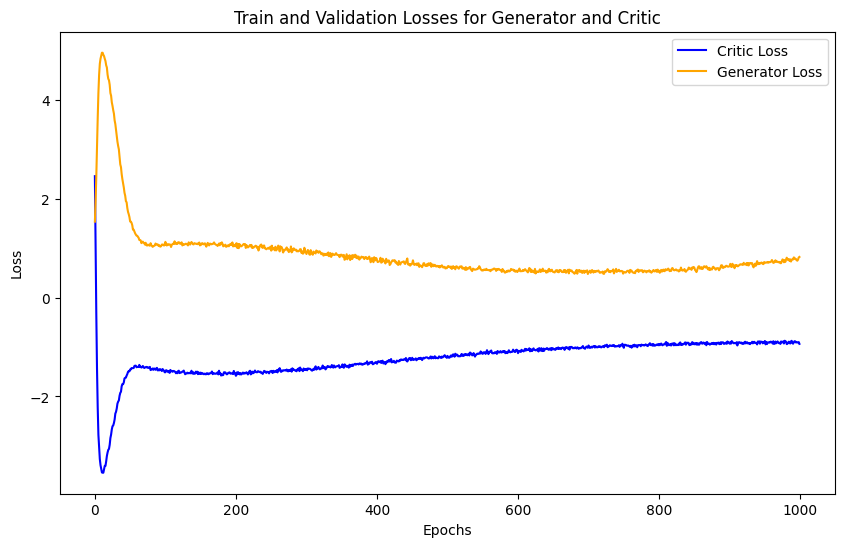

In [5]:
crit_loss, gen_loss = wctgan.fit(
    data_set,
    n_epochs=1000
)

fig = plot_gan_losses(crit_loss, gen_loss)
fig.show()

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________
### Save and Load Model

In [6]:
wctgan.save()   # provide save part if you dont want to save it with the base path

wctgan_loaded = WCTGan()

wctgan_loaded.load()

________________________________________________________________________________________________________________________________________________________
##  Create New Conditional Data

To create data given a condition, just create a DataFrame that represents the condition. 
Generating data with a condition doesn’t guarantee that all generated data will strictly 
adhere to that condition, but it will influence the generation process.

If you want to create data with no specific condition, simply pass the number of points 
you want to generate.

In [18]:
cond_df = pd.DataFrame([{"target" : 1}]*160)
syn_df_ = wctgan_loaded.gen(cond_df=cond_df)  

# or
syn_df = wctgan.gen(160)  

print(syn_df)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0             6.399919          3.299845           5.395297          1.299883   
1             5.121543          3.399882           1.635910          0.199928   
2             4.505751          3.199863           1.316541          0.199938   
3             4.961134          3.399843           1.499936          0.099858   
4             6.399930          2.999891           5.076099          1.899891   
..                 ...               ...                ...               ...   
155           5.599940          2.999932           1.678530          0.199915   
156           6.699968          2.699926           5.080351          1.399874   
157           4.520055          2.299937           1.323390          1.299840   
158           4.517377          3.199928           1.319290          0.199875   
159           4.959912          2.899905           1.322526          0.199824   

    target  
0        1  
1

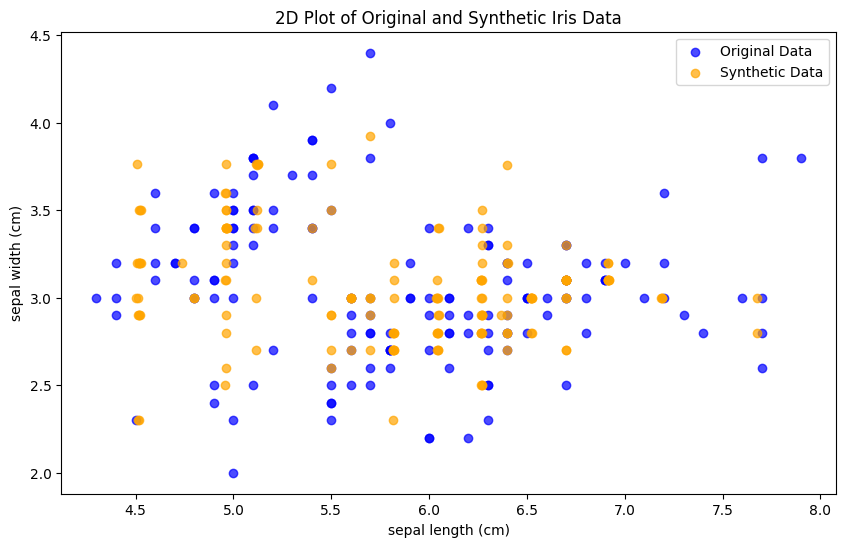

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df.iloc[:, 0], df.iloc[:, 1], color="blue", label="Original Data", alpha=0.7)
plt.scatter(syn_df.iloc[:, 0], syn_df.iloc[:, 1], color="orange", label="Synthetic Data", alpha=0.7)
plt.xlabel(iris['feature_names'][0])
plt.ylabel(iris['feature_names'][1])
plt.title("2D Plot of Original and Synthetic Iris Data")
plt.legend()
plt.show()

### Benchmark the Generated Data

There are various ways to benchmark generated data. In the benchmark class, several methods are implemented that you can use to validate your generated data. However, it’s worth noting that GANs often struggle to accurately replicate even simple data distributions

The first metric is a linear regression classifier used to distinguish real data from generated data. For this metric, lower values are better. Keep in mind that we have 160 real and 160 generated data points, meaning a random guess would achieve around 50% accuracy. Therefore, any score near 50% or lower is considered ideal.

In [20]:
benchmark = Benchmark()
mean_lr = benchmark.mean_lr(df, syn_df)

print(mean_lr)

0.3935483870967742


Therefore, we could use a classifier that is a better detector. For this purpose, we employ a mean Random Forest Classifier.

In [21]:
mean_rf = benchmark.mean_rfc(df, syn_df)

print(mean_rf)

0.835483870967742


Now we can look at a pairwise column correlations plot that shows the absolute difference between the real data covariance and the generated data covariance (lower indicates better performance). 

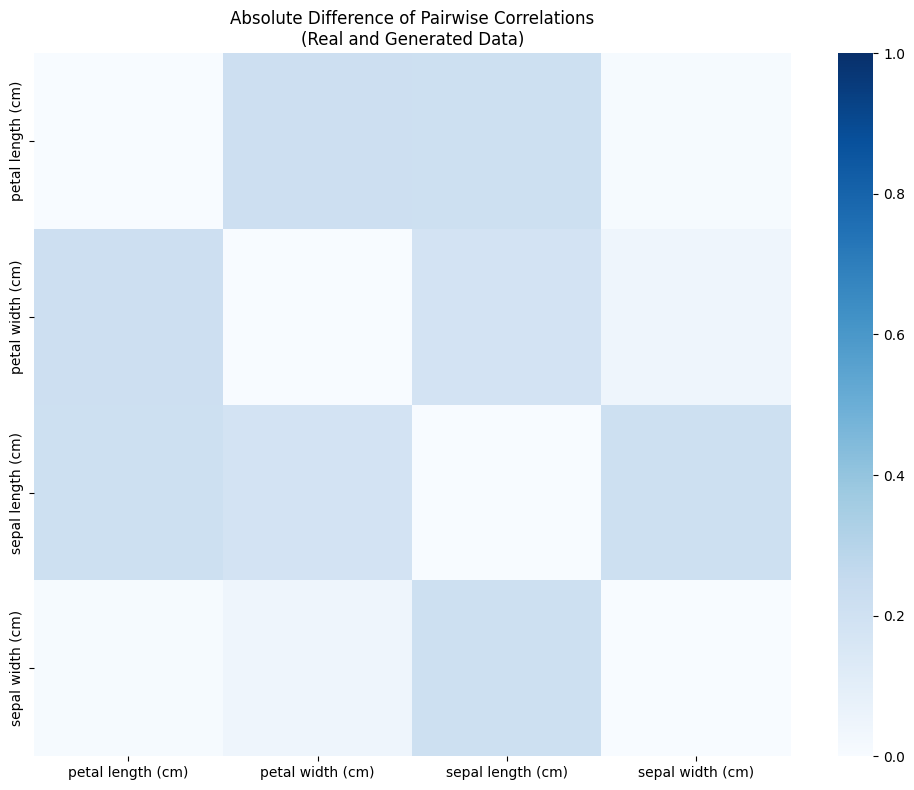

In [17]:
benchmark.absCorrPlot(df, syn_df, cat_cols=["target"]);

Now we can look at a covariance plot that shows the absolute difference between the real data covariance and the generated data covariance (lower indicates better performance). 

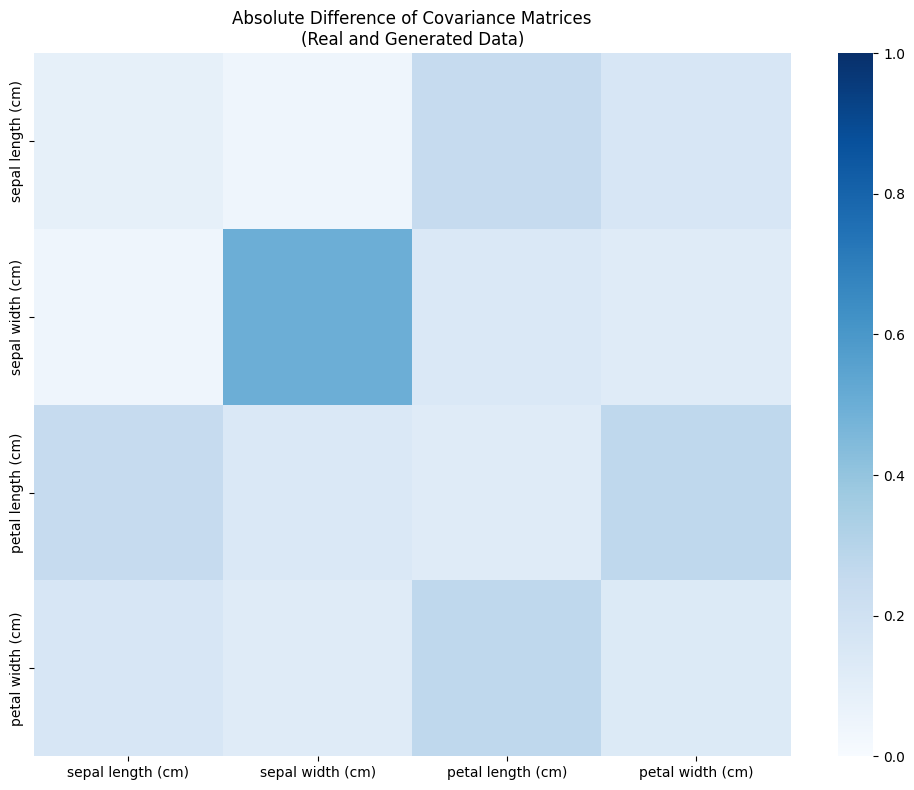

In [12]:
benchmark.absCovPlot(df, syn_df, cat_cols=["target"]);